In [2]:
from glob import glob
import rasterio as rs
import rasterio.features
from rasterio.plot import show
from dbfread import DBF
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rasterio.warp import reproject, Resampling
from pyrsgis.convert import changeDimension

In [3]:
#go through the Landsat 8 satellite optical image and puts them into a list which is then converted into a numpy array

path = 'Desktop/dynamic_world_test 2/LC08_L1TP_023035_20190601_20190605_01_T1.sm/'

training_bands = glob(f"{path}LC08_L1TP_023035_20190601_20190605_01_T1_B?.TIF")
training_bands.sort()
training_bands.append(str(path) + "LC08_L1TP_023035_20190601_20190605_01_T1_B10.TIF")
training_bands.append(str(path) + "LC08_L1TP_023035_20190601_20190605_01_T1_B11.TIF")

optic_imgs_lst = []
optic_np_lst = []

for i in training_bands:
    dataset = rs.open(i)
    optic_imgs_lst.append(dataset)
    optic_np_lst.append(dataset.read(1))
    
optic_imgs = np.asarray(optic_np_lst)

print(len(optic_imgs))
print(len(optic_imgs[0]))
print(len(optic_imgs[0][0]))

10
7701
7561


In [4]:
#Get the set of images for the testing set
path = 'Desktop/dynamic_world_test 2/LC08_L1TP_023035_20191023_20191030_01_T1.sm/'

training_bands = glob(f"{path}LC08_L1TP_023035_20191023_20191030_01_T1_B?.TIF")
training_bands.sort()
training_bands.append(str(path) + "LC08_L1TP_023035_20191023_20191030_01_T1_B10.TIF")
training_bands.append(str(path) + "LC08_L1TP_023035_20191023_20191030_01_T1_B11.TIF")

xtest_lst = []
xtest_np_lst = []

for i in training_bands:
    dataset = rs.open(i)
    xtest_lst.append(dataset)
    xtest_np_lst.append(dataset.read(1))
    
xtest_imgs = np.asarray(optic_np_lst)
print(xtest_imgs.ndim)

3


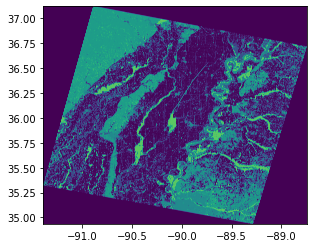

<AxesSubplot:>

In [11]:
#Getting the CDL crop class data

cdl_fp = r'Desktop/dynamic_world_test 2/CDL_2019_LS8_Coverage_clip_20221215094556_1977944902/CDL_2019_clip_20221215094556_1977944902.tif'
cdl_img = rs.open(cdl_fp) 

show(cdl_img)

In [12]:
print("CDL Image: width=" + str(cdl_img.width) + "and height=" + str(cdl_img.height))
print("Landsat8 training Band5: width=" + str(optic_imgs_lst[4].width) + "and height=" + str(optic_imgs_lst[4].height))

img = cdl_img.read(1)

CDL Image: width=8136and height=6706
Landsat8 training Band5: width=7561and height=7701


In [13]:
#Get the classifation table for the CDL

table = DBF('Desktop/dynamic_world_test 2/CDL_2019_LS8_Coverage_clip_20221215094556_1977944902/CDL_2019_clip_20221215094556_1977944902.tif.vat.dbf', load=True)
print(table.records[141])

OrderedDict([('VALUE', 141), ('RED', 0.576), ('GREEN', 0.8), ('BLUE', 0.576), ('CLASS_NAME', 'Deciduous Forest'), ('OPACITY', 1.0)])


In [14]:
#Get a subset to the common area between the bands and the CDL image and aligning the images to the correct area

kwargs = cdl_img.meta.copy()
raster = optic_imgs_lst[6]
kwargs.update({
    'crs': raster.crs,
    'transform': raster.transform,
    'width': raster.width,
    'height': raster.height
})

with rasterio.open('reprojected_CDL.tif', 'w', **kwargs) as dst:
    reproject(
        source=rasterio.band(cdl_img, 1),
        destination=rasterio.band(dst, 1),
        src_transform=cdl_img.transform,
        src_crs=cdl_img.crs,
        dst_transform=raster.transform,
        dst_crs=raster.crs,
        resampling=Resampling.nearest)

fix_fp = r'reprojected_CDL.tif'
cdl_img = rs.open(fix_fp) 
print(cdl_img.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 7561, 'height': 7701, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 648585.0,
       0.0, -30.0, 4107615.0)}


In [15]:
#Create np array so that each index refers to pixel at that index preparing the training set
xtrain = changeDimension(optic_imgs)
ytrain = changeDimension(cdl_img.read(1))
xtest = changeDimension(xtest_imgs)

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
(58227261, 10)
(58227261,)
(58227261, 10)


In [16]:
#Setting up the training set so that it is in the rihgt format to be passed through to the machine learning model

xtrain = xtrain / 65536.0
xtest = xtest / 65536.0
xtrain = xtrain.reshape((xtrain.shape[0], 1, 10))
xtest = xtest.reshape((xtest.shape[0], 1, 10))

print(xtrain.shape, ytrain.shape, xtest.shape)

(58227261, 1, 10) (58227261,) (58227261, 1, 10)


In [62]:
#Setting up training set classications

ytrain = ytrain / 255.0
print(xtest_lst[0].meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7561, 'height': 7701, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(30.0, 0.0, 648885.0,
       0.0, -30.0, 4107615.0)}


In [42]:
from tensorflow import keras
#Set up the machine learning model and then fit it based on the training data

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, 10)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(xtrain, ytrain, epochs=2)

Epoch 1/2
1819602/1819602 [==============================] - 4087s 2ms/step - loss: 6.4392e-05 - accuracy: 0.2361
Epoch 2/2
1819602/1819602 [==============================] - 2044s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2361


In [43]:
#Using the machine learning model to predict CDL based on the given test set of landsat8 images

predicted = model.predict(xtest)

1819602/1819602 [==============================] - 4016s 2ms/step


In [69]:
#Reshaping and putting the prediction output of the machine learning alogithm as a satellite GeoTiff file 

ds = xtest_lst[0]
prediction = np.reshape(predicted, (7701, 7561))
prediction = prediction * 255

transform = xtest_lst[0].transform

new_dataset = rs.open('CDLfromtestdata.tif', 'w', driver='GTiff',
                            height = prediction.shape[0], width = prediction.shape[1],
                            count=1, dtype=str(prediction.dtype),
                            crs='+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs',
                            transform=transform)

new_dataset.write(prediction, 1)
new_dataset.close()